#EDA


In [2]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import SGD

In [3]:
df = pd.read_csv('/content/DataLiIon_SuhuVoltase.xlsx - Sheet1 (1).csv')

In [4]:
df

,suhu,voltase,data ke,Unnamed: 3
0,42,4.026,1,NaN
1,42,4.026,2,NaN
2,42,4.026,3,NaN
3,43,4.163,4,NaN
4,43,4.152,5,NaN
...,...,...,...,...
715,36,4.393,716,NaN
716,36,4.393,717,NaN
717,36,4.393,718,NaN
718,36,4.396,719,NaN


In [5]:
df = df.iloc[:,0:2]

In [6]:
df

,suhu,voltase
0,42,4.026
1,42,4.026
2,42,4.026
3,43,4.163
4,43,4.152
...,...,...
715,36,4.393
716,36,4.393
717,36,4.393
718,36,4.396


In [7]:
df.describe()

,suhu,voltase
count,720.000000,720.000000
mean,38.862500,4.377671
std,1.745006,0.119771
min,36.000000,4.026000
25%,38.000000,4.281000
50%,39.000000,4.414000
75%,39.000000,4.488000
max,43.000000,4.503000


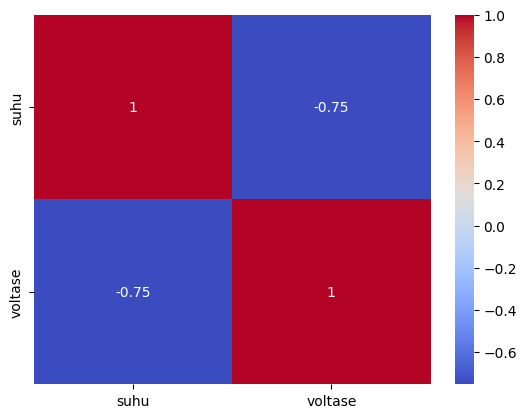

In [8]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

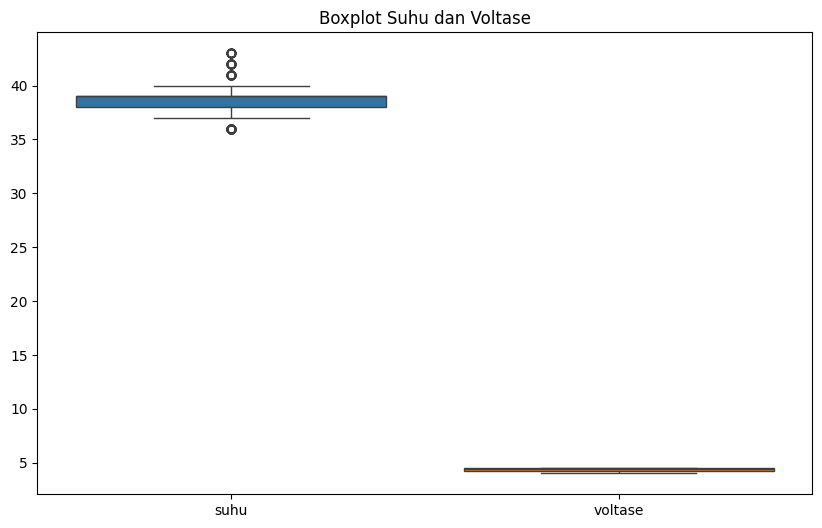

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot Suhu dan Voltase')
plt.show()

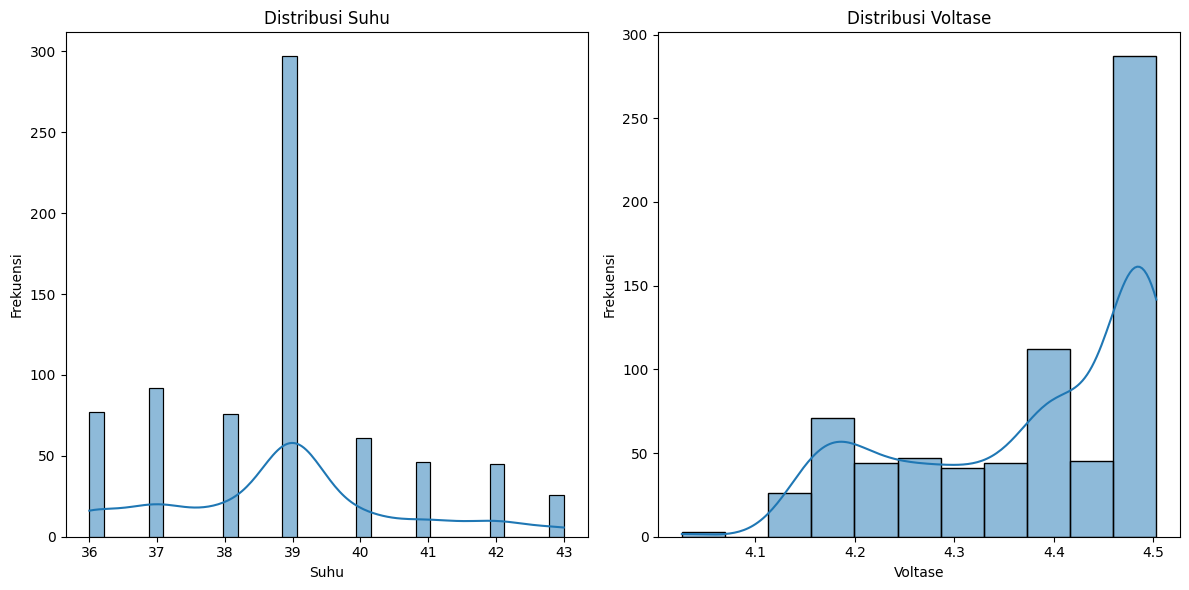

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['suhu'], kde=True)
plt.title('Distribusi Suhu')
plt.xlabel('Suhu')
plt.ylabel('Frekuensi')
plt.subplot(1, 2, 2)
sns.histplot(df['voltase'], kde=True)
plt.title('Distribusi Voltase')
plt.xlabel('Voltase')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

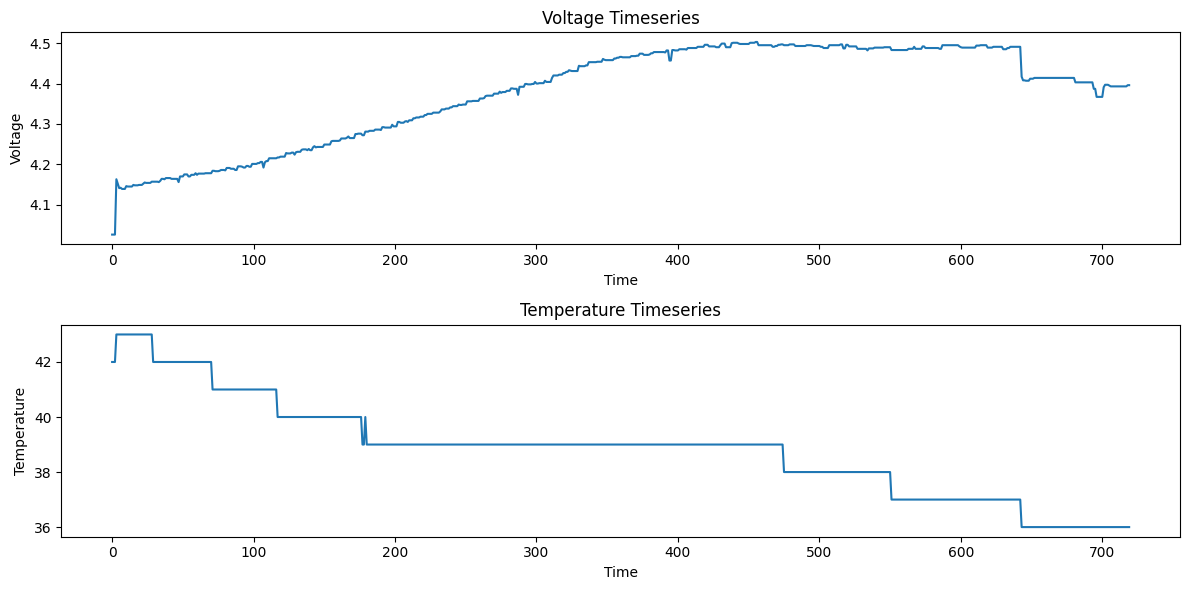

In [11]:

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df['voltase'])
plt.title('Voltage Timeseries')
plt.xlabel('Time')
plt.ylabel('Voltage')

plt.subplot(2, 1, 2)
plt.plot(df['suhu'])
plt.title('Temperature Timeseries')
plt.xlabel('Time')
plt.ylabel('Temperature')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

#Transoformasi dan Pembagian Data

In [18]:
scaler = MinMaxScaler()#standarisasi dulu supaya menyebar di [0,1]
data_scaled = scaler.fit_transform(df)#ini standarisasinya
# Split data menjadi train, validation, dan test set
train_data, temp_data = train_test_split(data_scaled, train_size=0.7, shuffle=False)#70% train #30% untuk val dan test
val_data, test_data = train_test_split(temp_data, train_size=0.5, shuffle=False)#1/2 dari 30% masing2 untuk train sama uji
#ini fungsi buat sequencenya
#butuh data x dan y masing2 dari urutan voltase dan suhu
def create_sequences(data_x, data_y, seq_length):
    xs, ys = [], []#buat list kosong buat menampung x dan y-nya
    for i in range(len(data_x) - seq_length):#i mulai dari data indeks ke 0 sampai ke sebelum panjang data-1
        # ini buat x-nya
        sequence_x = np.hstack([#buat stack/tumpukan dari indeks ke i sampai ke sebelum i + seq_length buat untuk variabel eksogen (voltase) dan endogen (suhu)
            data_x[i:(i + seq_length)],
            np.expand_dims(data_y[i:(i + seq_length)], axis=1)
 ])
        xs.append(sequence_x)
        #ini buat y-nya
        ys.append(data_y[i + seq_length])#ini ambil data ke i+seqlength
    return np.array(xs), np.array(ys)#jadikan larik/array
seq_length = 1#seq_length ini timestep #data ke-t+1 dipengaruhi oleh data ke-t
X_train, y_train = create_sequences(train_data[:, 1:], train_data[:, 0], seq_length)#buat array untuk x dan y train dari data train
X_val, y_val = create_sequences(val_data[:, 1:], val_data[:, 0], seq_length)#buat array untuk x dan y val dari data val
X_test, y_test = create_sequences(test_data[:, 1:], test_data[:, 0], seq_length)#buat array untuk x dan y test dari data uji


#VARIASI 10, 0.01, 50

## TRAIN-VAL VARIASI 10, 0.01, 50

In [44]:
# model2 keluarga rnn yang dipakai
def build_rnn_model(layer_type):
    model = Sequential()#modelnya sequential
    #layer 1, 2, 3 konstan layernya + dense 1 neuron aja (prediksi kontinu soalnya)
    model.add(layer_type(50, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(50, activation='tanh',return_sequences=True))
    model.add(layer_type(50, activation='relu'))#kasih relu (khawatir negatif walau jarang juga)
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.01), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=10,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")


Training SimpleRNN...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0108 - val_loss: 0.0041
Epoch 2/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.8272e-04 - val_loss: 0.0055
Epoch 3/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.8098e-04 - val_loss: 0.0028
Epoch 4/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2384e-04 - val_loss: 0.0037
Epoch 5/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7701e-04 - val_loss: 0.0024
Epoch 6/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8764e-04 - val_loss: 8.7974e-04
Epoch 7/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2385e-04 - val_loss: 0.0021
Epoch 8/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5354e-04 - val_loss: 0.0019
Epoch 9/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7376e-04 - val_loss: 0.0019
Epoch 10/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7664e-04 - val_loss: 0.0015
SimpleRNN Loss: 0.0015225255629047751
Training GRU...
Epoch 1/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - lo

## PLOT TRAIN-VAL VARIASI 10, 0.01, 50

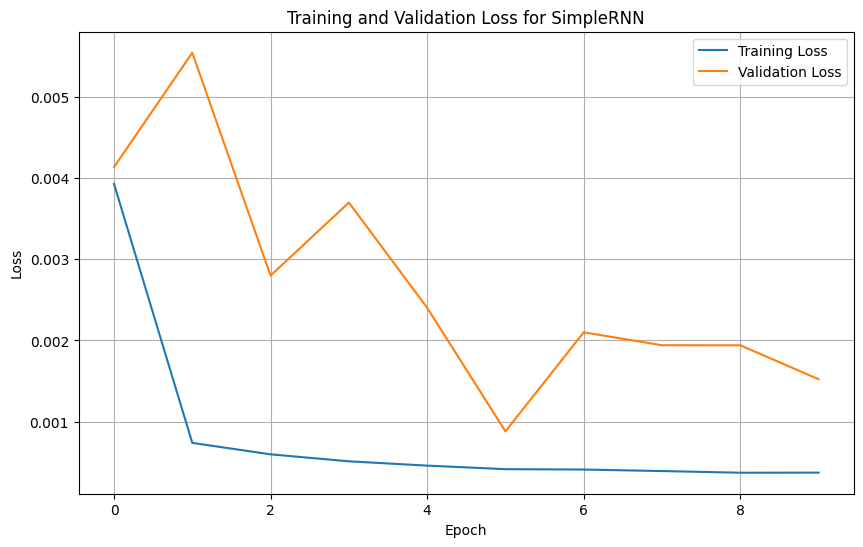

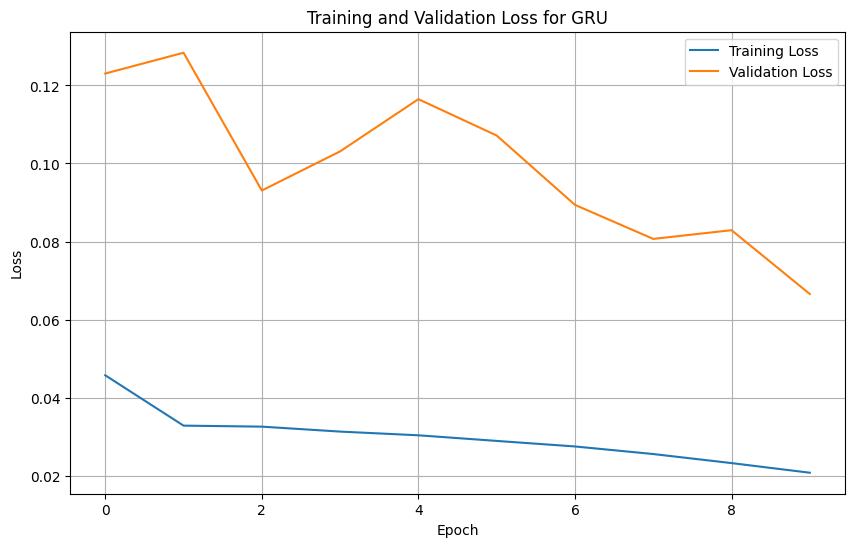

In [45]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##PLOT UJI DAN PERFORMA UJI VARIASI 10, 0.01, 50

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


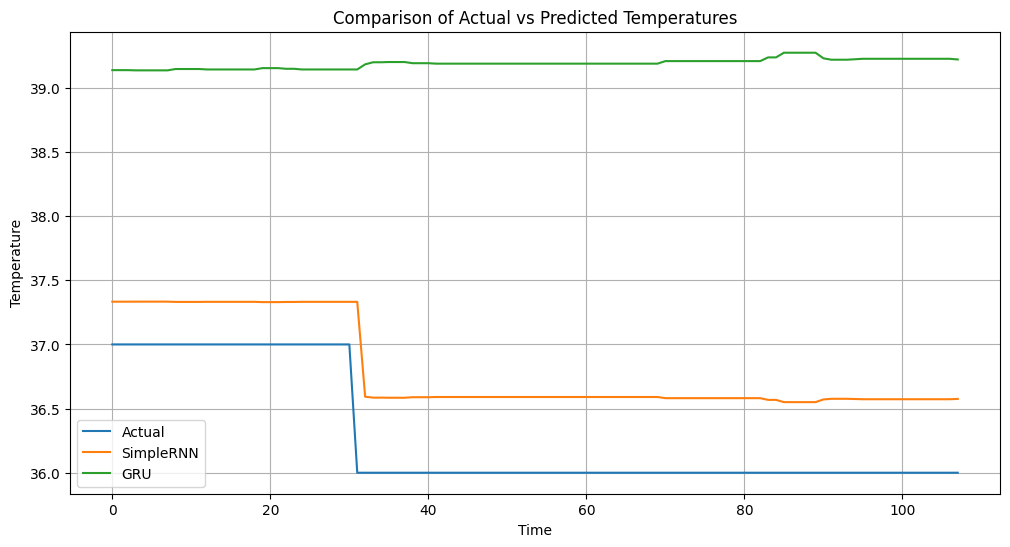

MSE for SimpleRNN: 0.2858158567385679
MSE for GRU: 8.655157689704572


In [46]:


predictions = {}#buat dictionary
for name, model in models.items():#untuk setiap pair nama dan modelnya
    predictions[name] = model.predict(X_test)#prediksi dengan masukan x_test supaya dapat estimasi ytest

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]#dilakukan pengembalian nilai semula
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]
plt.figure(figsize=(12, 6))#ini plotnya
plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():#untuk setiap model dan hasil prediksinya masing2
   mse = mean_squared_error(y_test_original, pred)#hitung MSE (rerata kesalahan terkuadrat)
   print(f"MSE for {name}: {mse}")#print dan tambahkan formating biar lebih jelas jadinya

# VARIASI 10, 0.01, 100

## TRAIN-VAL 10, 0.01, 100

In [41]:

def build_rnn_model(layer_type):
    model = Sequential()
    #saat masih return sequences=T maka diberi aktivasi tanh di akhirnya
    #saat return sequences=F maka digunakan relu (khawatir nilai negatif padahal penggunaan gawai tidak pernah di bawah suhu 0)
    model.add(layer_type(100, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(100, activation='tanh',return_sequences=True))
    model.add(layer_type(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.01), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=10,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")


Training SimpleRNN...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0283 - val_loss: 0.0037
Epoch 2/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0112e-04 - val_loss: 0.0029
Epoch 3/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2970e-04 - val_loss: 0.0030
Epoch 4/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7092e-04 - val_loss: 0.0027
Epoch 5/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0040e-04 - val_loss: 0.0017
Epoch 6/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5576e-04 - val_loss: 0.0017
Epoch 7/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7061e-04 - val_loss: 0.0016
Epoch 8/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3068e-04 - val_loss: 0.0016
Epoch 9/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7605e-04 - val_loss: 0.0013
Epoch 10/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8815e-04 - val_loss: 0.0012
SimpleRNN Loss: 0.0011629111832007766
Training GRU...
Epoch 1/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 

## PLOT TRAIN-VAL 10, 0.01, 100

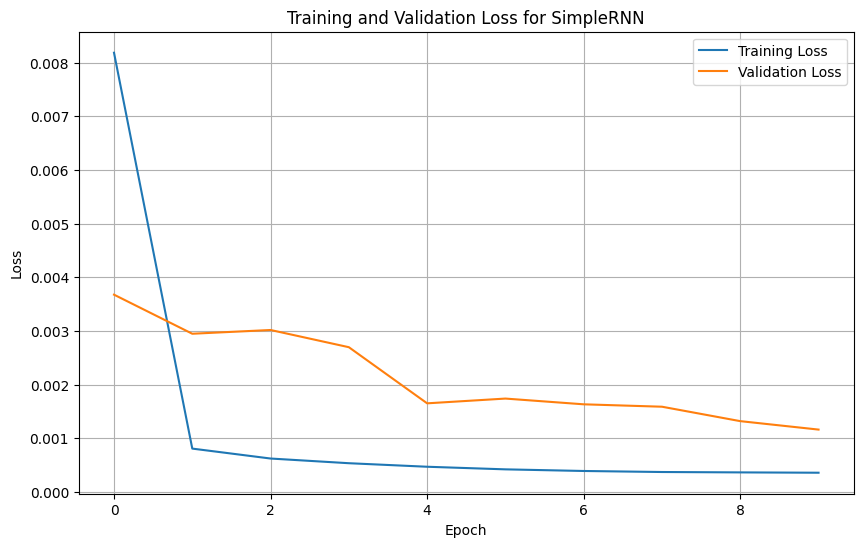

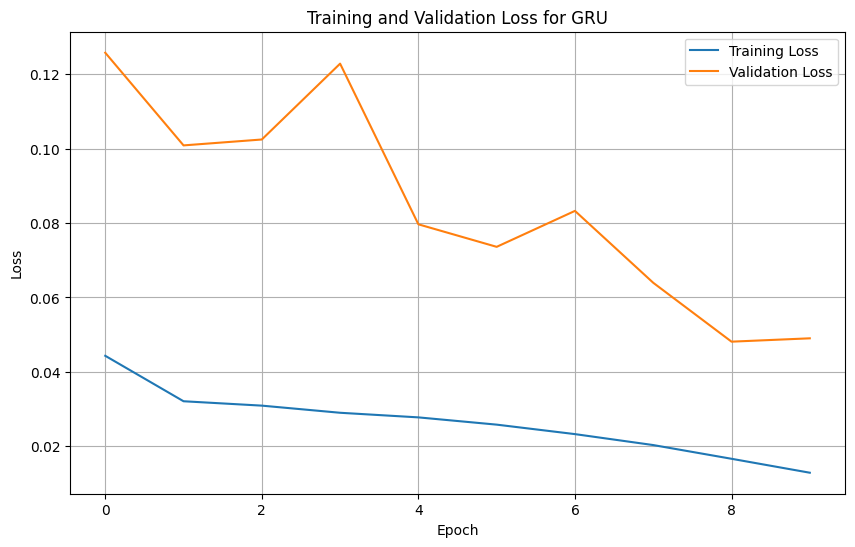

In [42]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##PLOT UJI DAN PEFRFORMA UJI 10, 0.01, 100

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


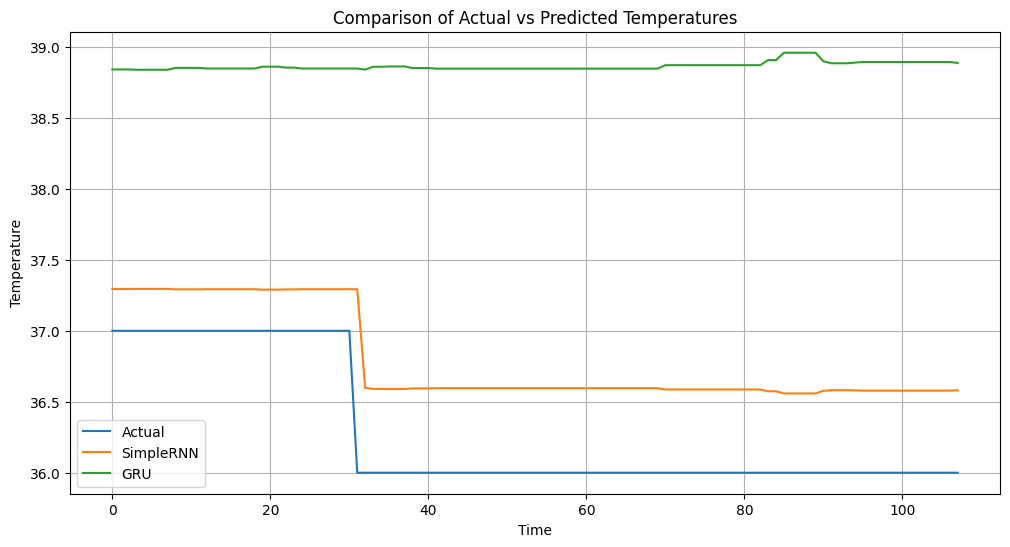

MSE for SimpleRNN: 0.2826296305415949
MSE for GRU: 6.861275828771021


In [43]:


predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]

plt.figure(figsize=(12, 6))

plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():
   mse = mean_squared_error(y_test_original, pred)
   print(f"MSE for {name}: {mse}")

#VARIASI 10, 0.02, 50

##VAL-TRAIN 10, 0.02, 50

In [38]:

def build_rnn_model(layer_type):
    model = Sequential()
    model.add(layer_type(50, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(50, activation='tanh',return_sequences=True))
    model.add(layer_type(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.02), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=10,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")


Training SimpleRNN...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0120 - val_loss: 0.0020
Epoch 2/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.1831e-04 - val_loss: 0.0012
Epoch 3/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7984e-04 - val_loss: 0.0015
Epoch 4/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6798e-04 - val_loss: 7.4759e-04
Epoch 5/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6757e-04 - val_loss: 8.5088e-04
Epoch 6/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8718e-04 - val_loss: 6.4591e-04
Epoch 7/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1315e-04 - val_loss: 5.5938e-04
Epoch 8/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5447e-04 - val_loss: 7.4280e-04
Epoch 9/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4165e-04 - val_loss: 5.9427e-04
Epoch 10/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3275e-04 - val_loss: 7.1381e-04
SimpleRNN Loss: 0.0007138050859794021
Training GRU...
Epoch 1/10
502/502 ━━━━━━━━━━━━━

## PLOT VAL-TRAIN 10, 0.02, 50

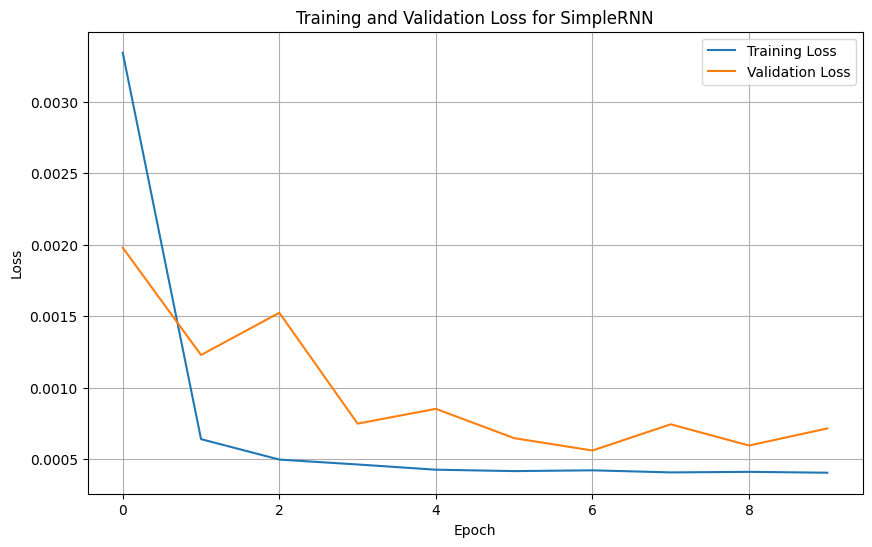

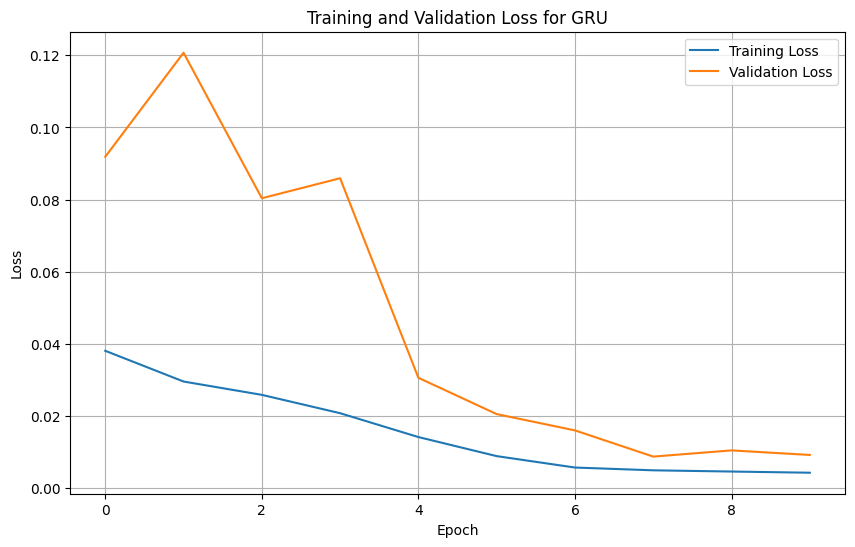

In [39]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##PERFORMA DAN PLOT UJI VARIASI 10, 0.02, 50

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


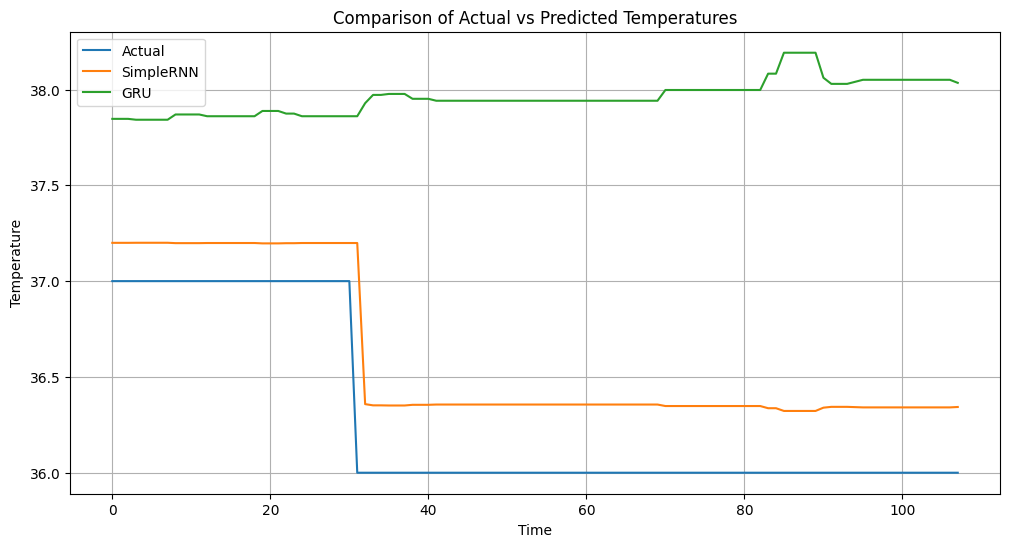

MSE for SimpleRNN: 0.10998207545910393
MSE for GRU: 3.058744597458254


In [40]:


predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]

plt.figure(figsize=(12, 6))

plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():
   mse = mean_squared_error(y_test_original, pred)
   print(f"MSE for {name}: {mse}")

#VARIASI 10, 0.02, 100

##TRAIN-VAL VARIASI 10, 0.02, 100

In [35]:
#ini buat pilih model keluarga rnn mana yang dipakai
def build_rnn_model(layer_type):
    model = Sequential()
    #input shape (1,2) itu maksudnya 1 baris mewakili timestep dan 2 fitur mewakili fitur yang digunakan untuk memprediksi data
    model.add(layer_type(100, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(100, activation='tanh',return_sequences=True))
    model.add(layer_type(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.02), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=10,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")


Training SimpleRNN...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0230 - val_loss: 0.0073
Epoch 2/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.9537e-04 - val_loss: 0.0045
Epoch 3/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5566e-04 - val_loss: 0.0040
Epoch 4/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3497e-04 - val_loss: 0.0047
Epoch 5/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6716e-04 - val_loss: 0.0038
Epoch 6/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2397e-04 - val_loss: 0.0037
Epoch 7/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7445e-04 - val_loss: 0.0040
Epoch 8/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9135e-04 - val_loss: 0.0040
Epoch 9/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4421e-04 - val_loss: 0.0038
Epoch 10/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9462e-04 - val_loss: 0.0031
SimpleRNN Loss: 0.003148492891341448
Training GRU...
Epoch 1/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0

## PLOT TRAIN-VAL VARIASI 10, 0.02, 100

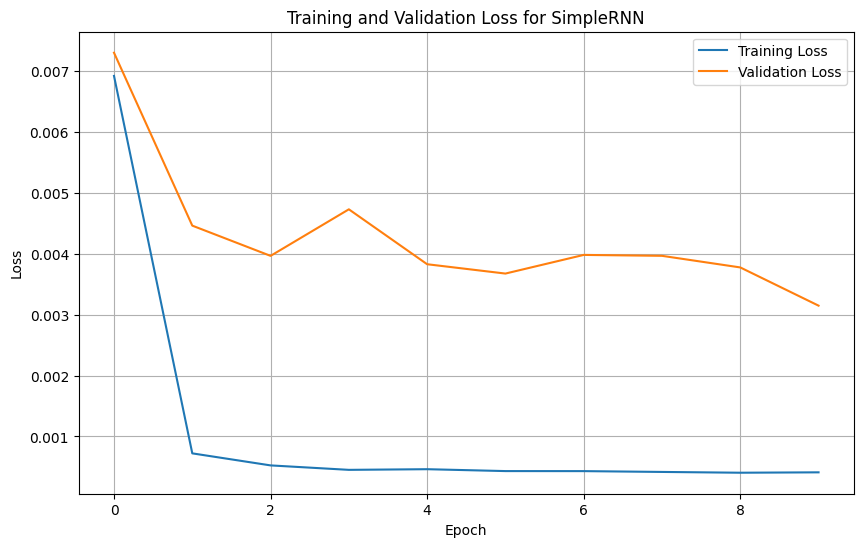

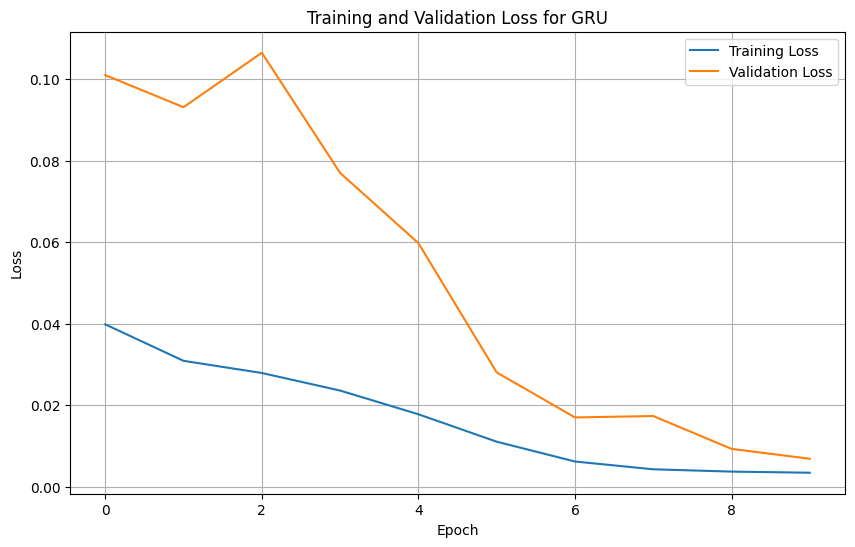

In [36]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## PERFORMA UJI PLOT UJI VARIASI 10, 0.02, 100

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


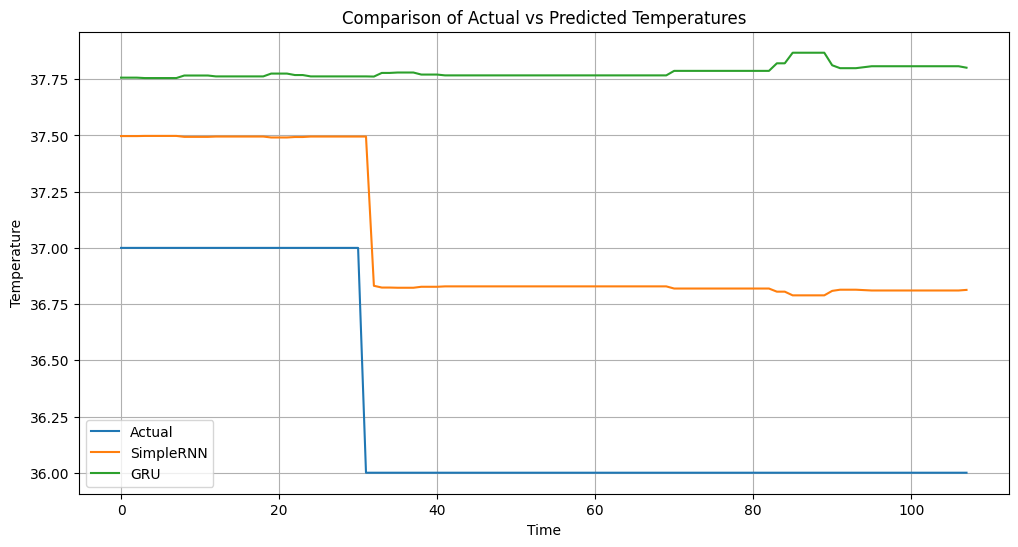

MSE for SimpleRNN: 0.5636014805957664
MSE for GRU: 2.448247279873882


In [37]:


predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]

plt.figure(figsize=(12, 6))

plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():
   mse = mean_squared_error(y_test_original, pred)
   print(f"MSE for {name}: {mse}")

#VARIASI 20, 0.01, 50

## TRAIN-VAL

In [32]:
#model2 keluarga rnn yang dipakai
def build_rnn_model(layer_type):
    model = Sequential()
    model.add(layer_type(50, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(50, activation='tanh',return_sequences=True))
    model.add(layer_type(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.01), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=20,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")


Training SimpleRNN...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0208 - val_loss: 0.0016
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.8560e-04 - val_loss: 0.0018
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6674e-04 - val_loss: 0.0017
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6759e-04 - val_loss: 8.7564e-04
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7474e-04 - val_loss: 0.0019
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7684e-04 - val_loss: 0.0016
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7206e-04 - val_loss: 0.0014
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8434e-04 - val_loss: 0.0016
Epoch 9/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.5024e-04 - val_loss: 9.3385e-04
Epoch 10/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6041e-04 - val_loss: 7.4866e-04
Epoch 11/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4048e-04 - val_loss: 9.2471e-04
Epoch 1

## PLOT TRAIN-VAL

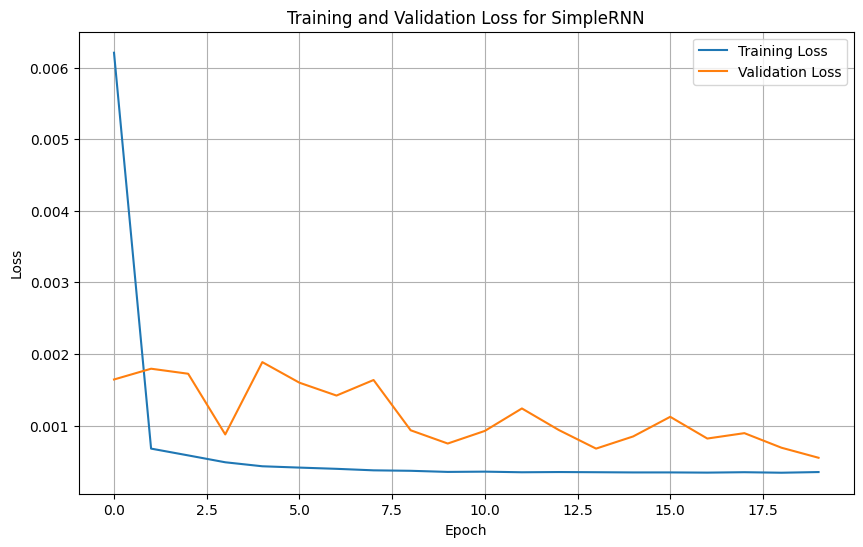

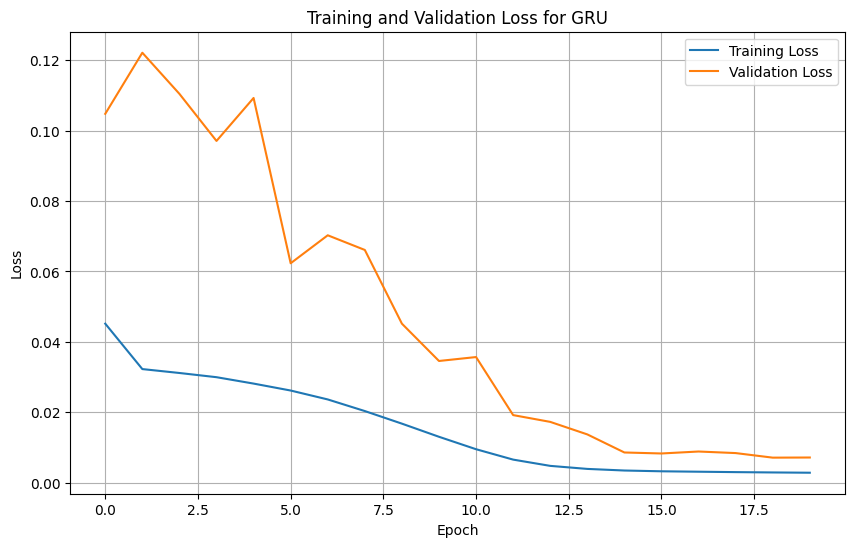

In [33]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## UJI

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


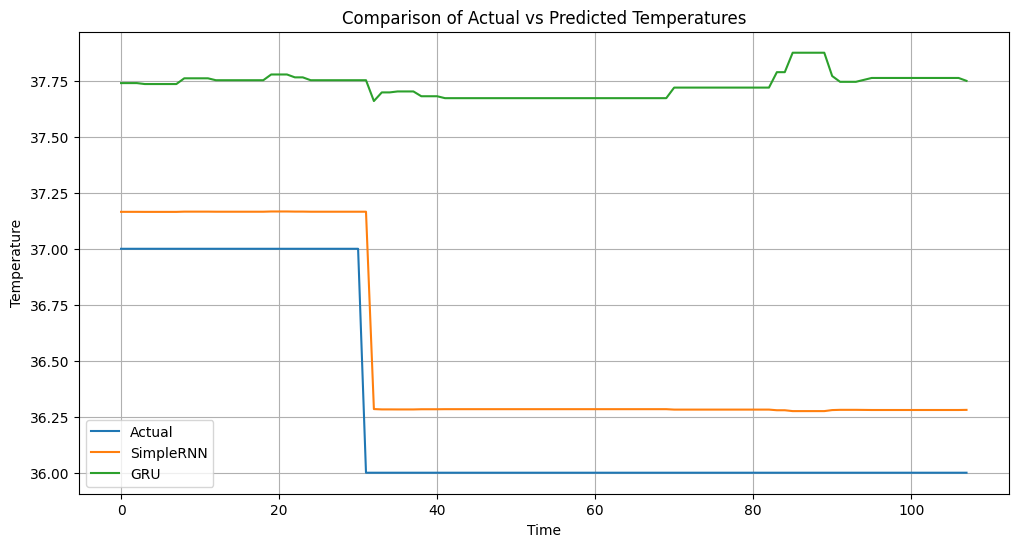

MSE for SimpleRNN: 0.07634534508879706
MSE for GRU: 2.2744207487832884


In [34]:


predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]

plt.figure(figsize=(12, 6))

plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():
   mse = mean_squared_error(y_test_original, pred)
   print(f"MSE for {name}: {mse}")

#VARIASI 20, 0.01, 100

## VAL-TRAIN

In [29]:
# model2 kelaurga rnn yang dipakai
def build_rnn_model(layer_type):
    model = Sequential()
    model.add(layer_type(100, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(100, activation='tanh',return_sequences=True))
    model.add(layer_type(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.01), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=20,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")


Training SimpleRNN...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0279 - val_loss: 0.0068
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1256e-04 - val_loss: 0.0044
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9631e-04 - val_loss: 0.0038
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0428e-04 - val_loss: 0.0036
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1052e-04 - val_loss: 0.0027
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3806e-04 - val_loss: 0.0033
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4329e-04 - val_loss: 0.0035
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2436e-04 - val_loss: 0.0036
Epoch 9/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2911e-04 - val_loss: 0.0034
Epoch 10/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1680e-04 - val_loss: 0.0032
Epoch 11/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7758e-04 - val_loss: 0.0028
Epoch 12/20
502/502 ━━━

## PLOT VAL-TRAIN

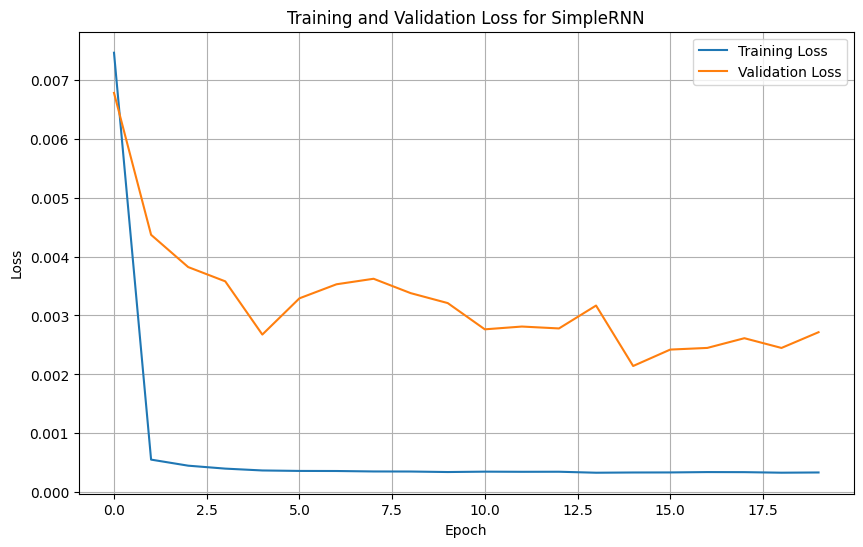

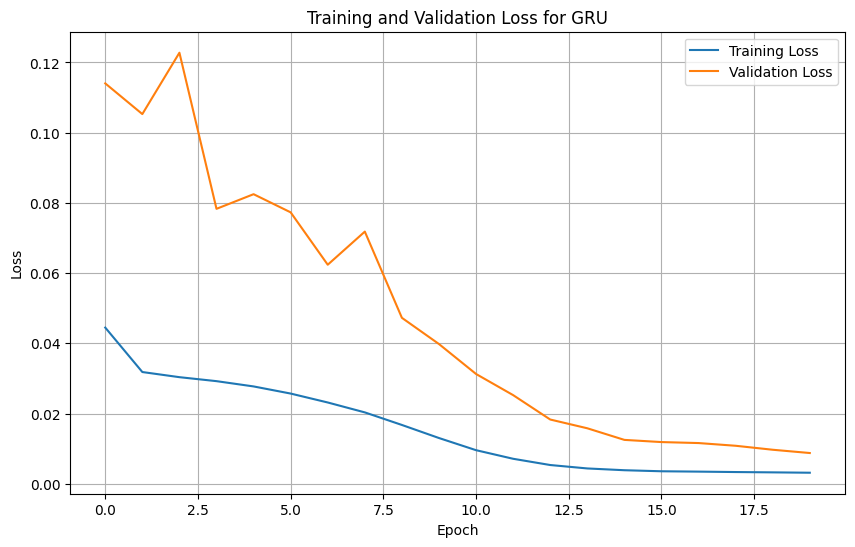

In [30]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## PERFORMA UJI

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


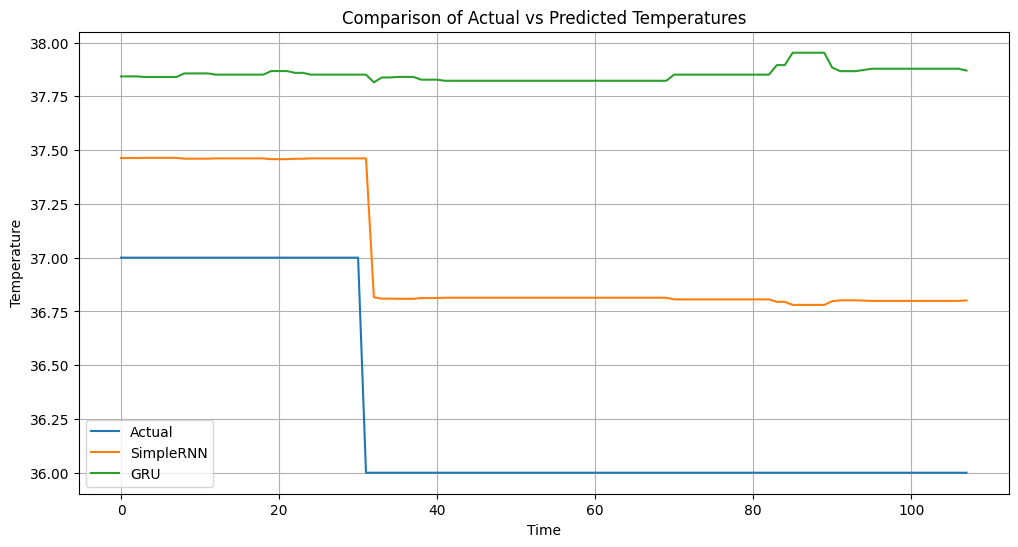

MSE for SimpleRNN: 0.5381001113553928
MSE for GRU: 2.6537611109109736


In [31]:


predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]

plt.figure(figsize=(12, 6))

plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():
   mse = mean_squared_error(y_test_original, pred)
   print(f"MSE for {name}: {mse}")

#VARIASI 20, 0.02, 50

## VAL-TRAIN

In [47]:
#model2 keluarga rnn yang dipakai
def build_rnn_model(layer_type):
    model = Sequential()
    model.add(layer_type(50, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(50, activation='tanh',return_sequences=True))
    model.add(layer_type(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.02), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=20,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")
#menampilkan loss sepanjang pelatihan dan mengembalikan loss terakhir setelah pelatihan terakhir selesai
#kepentingan menampilkan losss sepanjang pelatih berguna untuk melihat seberapa sering model mengalami under atau overfitting
#harapannya frekuensi under atau overfitting mampu memberikan gambaran bagaimana model nanti bekerja pada data uji (cenderung under, overfit, atau bahkan lebih baik dari saat melatihnya)

Training SimpleRNN...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0230 - val_loss: 0.0054
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2339e-04 - val_loss: 0.0054
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5492e-04 - val_loss: 0.0046
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9639e-04 - val_loss: 0.0045
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9631e-04 - val_loss: 0.0030
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4196e-04 - val_loss: 0.0034
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2438e-04 - val_loss: 0.0025
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1674e-04 - val_loss: 0.0033
Epoch 9/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4093e-04 - val_loss: 0.0026
Epoch 10/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1754e-04 - val_loss: 0.0027
Epoch 11/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0135e-04 - val_loss: 0.0022
Epoch 12/20
502/502 ━━━

## PLOT VAL-TRAIN

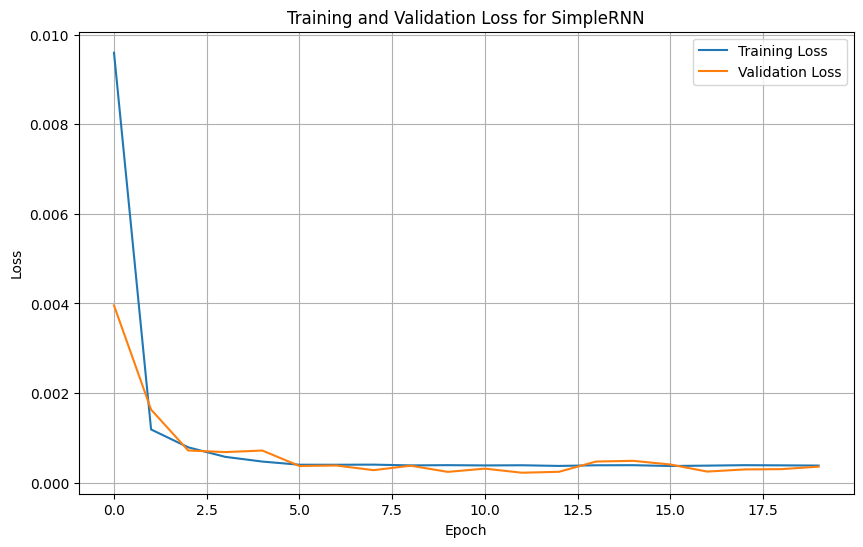

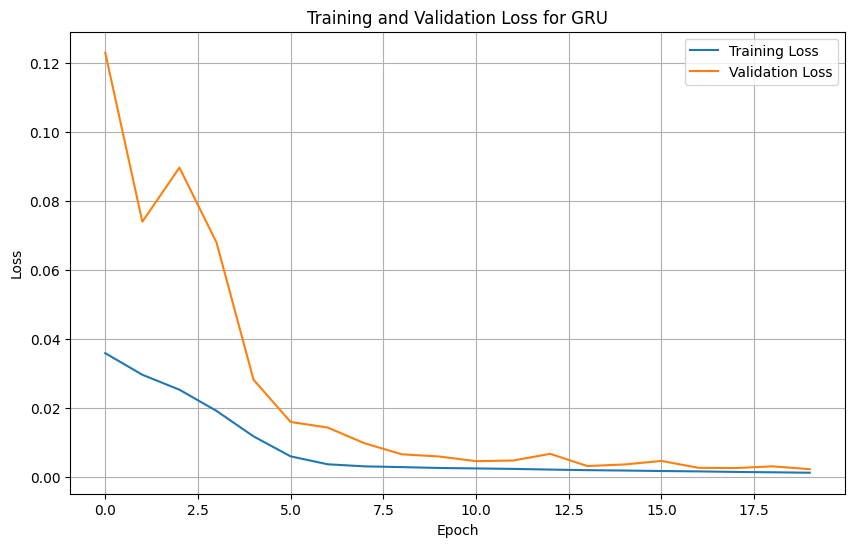

In [22]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## UJI

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


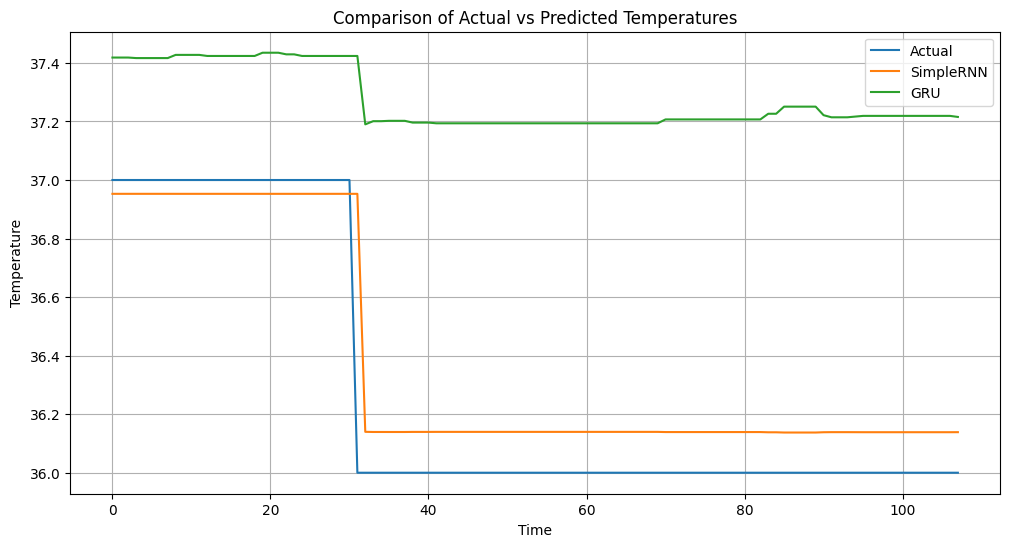

MSE for SimpleRNN: 0.02263542502030894
MSE for GRU: 1.095619734529464


In [25]:


predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]

plt.figure(figsize=(12, 6))

plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():
   mse = mean_squared_error(y_test_original, pred)
   print(f"MSE for {name}: {mse}")

#VARIASI 20, 0.02, 100

##VAL-TRAIN

In [26]:
#model2 keluarga rnn yang dipakai
def build_rnn_model(layer_type):
    model = Sequential()
    model.add(layer_type(100, activation='tanh', input_shape=(1, 2),return_sequences=True))##GANTI UNTUK VARIASI NEUORON
    model.add(layer_type(100, activation='tanh',return_sequences=True))
    model.add(layer_type(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=0.02), loss='mse')##GANTI UNTUK VARIASI LEARNING RATE
    return model
models = {
    "SimpleRNN": build_rnn_model(SimpleRNN),
    "GRU": build_rnn_model(GRU)
}
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=20,##GANTI UNTUK VARIASI EPOCHS##
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )
    histories[name] = history.history
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Loss: {loss}")


Training SimpleRNN...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0092 - val_loss: 0.0017
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.3437e-04 - val_loss: 0.0020
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4542e-04 - val_loss: 0.0016
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6620e-04 - val_loss: 0.0017
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9930e-04 - val_loss: 0.0013
Epoch 6/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.1604e-04 - val_loss: 0.0016
Epoch 7/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4138e-04 - val_loss: 0.0016
Epoch 8/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3299e-04 - val_loss: 0.0015
Epoch 9/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1789e-04 - val_loss: 0.0014
Epoch 10/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1532e-04 - val_loss: 0.0012
Epoch 11/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1292e-04 - val_loss: 0.0013
Epoch 12/20
502/502 ━━━

##PLOT VAL-TRAIN

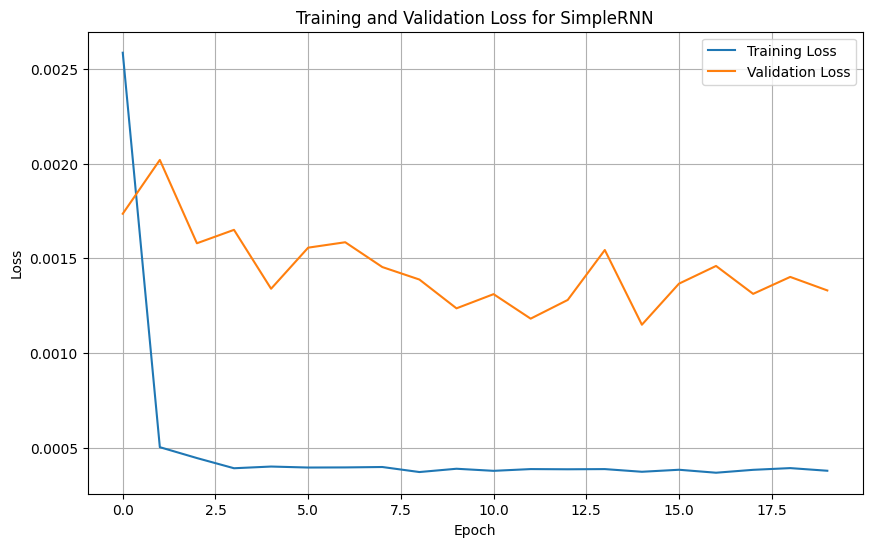

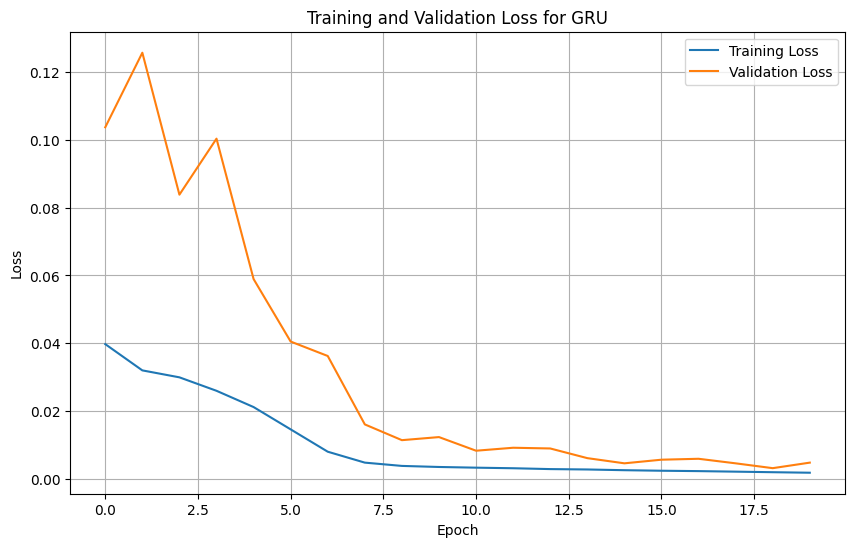

In [27]:
for name, history in histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##UJI

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


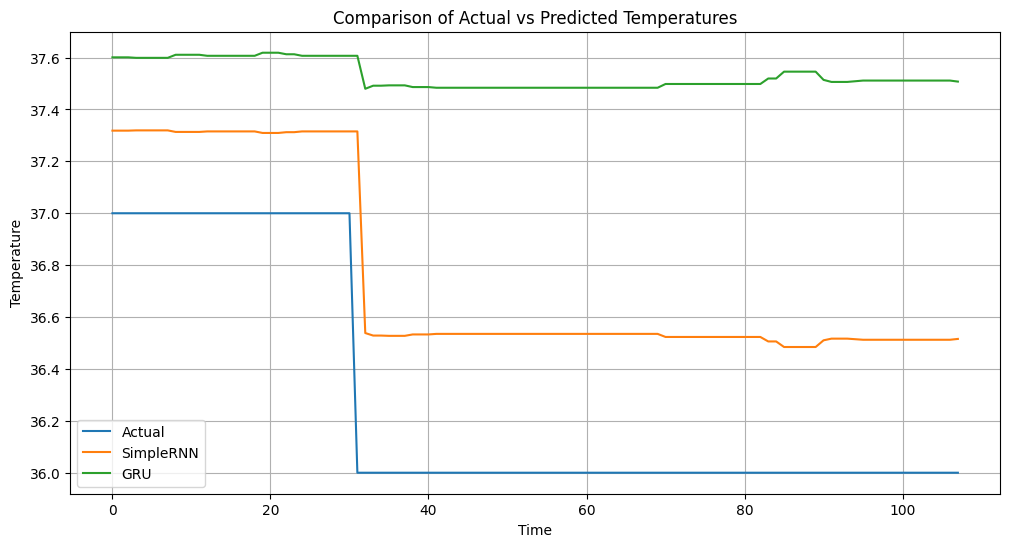

MSE for SimpleRNN: 0.23739344122319986
MSE for GRU: 1.7091864292582344


In [28]:


predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:,0]
for name, pred in predictions.items():
    predictions[name] = scaler.inverse_transform(np.concatenate((pred, np.zeros_like(pred)), axis=1))[:,0]

plt.figure(figsize=(12, 6))

plt.plot(y_test_original, label='Actual')
for name, pred in predictions.items():
    plt.plot(pred, label=name)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()
for name, pred in predictions.items():
   mse = mean_squared_error(y_test_original, pred)
   print(f"MSE for {name}: {mse}")